## Pairs Trading

This notebook contains sample code on testing out a pairs strategy using cointegration analysis

### Cointegration

Cointegration anaysis is a technique that is widely used. It can be used to find trading strategies based on the property of mean reversion. Cointegration analysis aims to find a grouping of time series (in this case, closing prices of stocks) that behaves as a stationary, or mean reverting process. When this process is below the mean, we go long. When it's above the mean, we go short the basket.

For financial data, it can be shown that returns are stationary but prices are not (see my R statistics code samples for this). However, we can find linear combination of price processes so that that such combination is stationary. The vector of coefficients we solve for is known as a cointegrating vector.

We will consider all of 2022, which as we know had significant turbulence, which should help our results look not-so-ideal.

In [2]:
import numpy as np
import pandas as pd

# We will uuse statsmodels library which can check for cointegration between 2 series
# coint uses the augmented Engle-Granger two step test
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [14]:
#Some popular stocks
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG', 'TSLA', 'QCOM', 'JPM', 'GS']

data = yf.download(
    symbol_list, 
    start='2022-01-01', 
    end='2023-01-01'
)['Adj Close']

[*********************100%***********************]  9 of 9 completed


In [39]:


##Pairwise cointegration analysis
## O(n^2) algorithm
#TODO: Apply multicointegration, e.g. Phillips-Ouliaris cointegration test
#Can be 0.10 to be more permissive, or 0.025, 0.01 to be more restrictive

def find_cointegrated_pairs(data, alpha_critical = 0.05):
    rows, cols = data.shape
    score_matrix = np.zeros(shape = (cols, cols))
    pvalue_matrix = np.ones(shape = (cols, cols))

    #Note that this returns in alphabetical order. keys[0] is AAPL. symbol_list[0] is META. The yfinance package returns in alphabetical order, openbb will return in the order you give it
    #keep it consistent!
    keys = data.keys()
    pairs = []

    for i in range(cols):
        for j in range(i+1, cols):
            #Extract the two time series
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            #See function spec. result is a tuple of the t-stat, the p-value, and the critical values for the test statistic at 1/5/10 levels
            #TODO: Can improve to use result[2] and a vecotrized check instead of a manual check with alpha_critical
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue

            if pvalue < alpha_critical:
                pairs.append((keys[i], keys[j]))
        
    return score_matrix, pvalue_matrix, pairs

alpha_critical = 0.05
scores, pvalues, pairs = find_cointegrated_pairs(data, alpha_critical = alpha_critical)

Now that we have our results, let's plot them to visualize it.

We can use a heatmap from seaborn. What we are doing is plotting the pvalues matrix. We are applying a color map to it to visualize the difference in pvalues. In this example, we choose red as the highest values and green as the lowest values. To prevent the whole thing from being colored, we apply a mask to ignore all pvalues above our alpha_critical value.

[('AAPL', 'AMZN'), ('META', 'QCOM')]


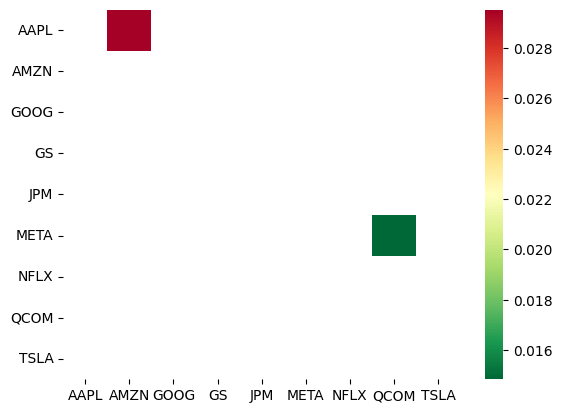

In [43]:
seaborn.heatmap(
    pvalues, 
    xticklabels=keys, 
    yticklabels=keys, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= alpha_critical)
)

print(pairs)

We see that we have two cointegrated series, AMZN/AAPL, and META/QCOM. We see this from our pairs variable and from the plot. NOTE: Remember, we used keys in our function, so we specify keys in the argument for this plot. Had we used symbol_list, we would have incorrect labels that wouldn't match pairs (try it on your end to see).

Let's look more closely at META/QCOM since it has a lower p-value.

[('AAPL', 'AMZN'), ('META', 'QCOM')]